In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import norm

In [4]:
# Setting Constants

#position boundaries
x_0 = 0
x_endpoints = np.linspace(0,2,101)

#time boundaries
t_i = 0
t_f = 6

#other constants
mass = 1
steps = 7
numb_paths = 1000

#array of times
times = np.linspace(t_i, t_f, steps)
dt = times[1] - times [0]
print(x_endpoints)

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.   1.02 1.04 1.06 1.08 1.1
 1.12 1.14 1.16 1.18 1.2  1.22 1.24 1.26 1.28 1.3  1.32 1.34 1.36 1.38
 1.4  1.42 1.44 1.46 1.48 1.5  1.52 1.54 1.56 1.58 1.6  1.62 1.64 1.66
 1.68 1.7  1.72 1.74 1.76 1.78 1.8  1.82 1.84 1.86 1.88 1.9  1.92 1.94
 1.96 1.98 2.  ]


# Basic Path function and action integral

In [5]:
#Creating the position generating function

def Pos_Gen(x0, xN, Steps, noise_scale =0.3): #Generates smooth paths with noise
    xs = np.linspace(x0, xN, Steps)
    noise = np.random.normal(0, noise_scale, size=Steps)
    noise[0] = 0.0
    noise[-1] = 0.0
    return xs + noise

In [6]:
#Creating function to evaluate the action integral for a path

def action_harmonic(positions, times, mass):

    #Input Validation
    if type(positions) != np.ndarray:
        raise TypeError("WARNING: position input is not a numpy array")
    if type(times) != np.ndarray:
        raise TypeError("WARNING: time input is not a numpy array")

    #Calculating the action using discrete steps and straight line approx
    S = 0
    for i in range(len(times)-1):
        dt = times[i+1] - times[i]
        dx = positions[i+1] - positions[i]
        T = 0.5 * mass * (dx/dt)**2
        V = 0.5 * (((positions[i]+positions[i+1])/2)**2)
        S +=dt*(T + V)

    return S

# Generating Paths and calculating weight of each path

In [7]:
paths = []
weights = []
x_end = []

for xN in x_endpoints:
    for _ in range(numb_paths):
        p = Pos_Gen(x_0, xN, steps)
        S = action_harmonic(p, times, mass)
        w = np.exp(-S)
        paths.append(p)
        weights.append(w)
        x_end.append(xN)

paths = np.array(paths)
weights = np.array(weights)
x_end = np.array(x_end)

print(paths[0])

[ 0.         -0.16855579 -0.47303497  0.35018331  0.56759291  0.07146979
  0.        ]


In [8]:
print(len(paths))
print(paths[1001])

101000
[ 0.         -0.05705591  0.14716364  0.66991023 -0.62121719  0.15903569
  0.02      ]


# Finding the groundstate wave function of the path

In [9]:
x_bins = np.linspace(0,2,101)

pdf_unnormalised, bin_edges = np.histogram(x_end, bins = x_bins, weights = weights)
x_centres = 0.5*(bin_edges[1:] + bin_edges[:-1])
dx = np.diff(x_bins)[0]

# normalize to integrate to 0.5 (since we only use x > 0)
area = np.sum(pdf_unnormalised * dx)
pdf = pdf_unnormalised / (2 * area)

# --- Analytic PDF for comparison (half side only) ---
phi_sq_analytic = (1/np.sqrt(np.pi)) * np.exp(-x_centres**2)
phi_sq_analytic /= 2 * np.sum(phi_sq_analytic * dx)  # normalize area to 0.5

# --- Check areas ---
print(f"Numerical PDF area: {np.sum(pdf*dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic*dx):.5f}")

Numerical PDF area: 0.50000
Analytic PDF area: 0.50000


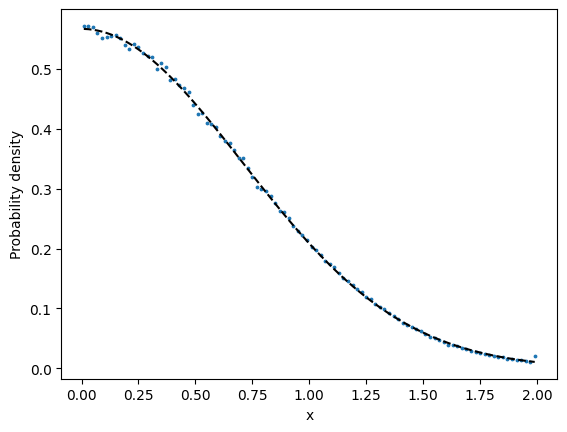

In [10]:
save_path = r"C:\Users\Sebastian\Documents\University work\Year 3\Computational Physics\Wavefunction.svg"

plt.figure(1)
plt.scatter(x_centres, pdf, label='Path integral estimate',s = 3)
plt.plot(x_centres, phi_sq_analytic, 'k--', label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x')
plt.ylabel('Probability density')
plt.savefig(save_path, bbox_inches='tight', format = 'svg')
plt.show()

In [11]:
i_099 = np.searchsorted(x_centres, 0.99)
i_101 = np.searchsorted(x_centres, 1.01)

# Fitting Model

In [12]:
#define model

def oscillator_model(x,A,B):
    return A*np.exp(-B*x**2)

p0_osc = [1/np.sqrt(np.pi), 1.00055]

In [13]:
popt_osc, cov_osc = opt.curve_fit(oscillator_model,
                                  x_centres,
                                  pdf,
                                  p0=p0_osc)

osc_err = np.sqrt(np.diag(cov_osc))

In [14]:
y_max = oscillator_model(x_centres,popt_osc[0]+osc_err[0],popt_osc[1]+osc_err[1])
y_min = oscillator_model(x_centres,popt_osc[0]-osc_err[0],popt_osc[1]-osc_err[1])

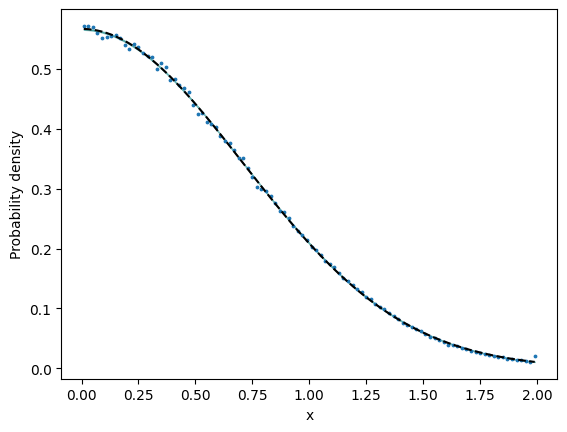

In [15]:
plt.figure(1)
plt.fill_between(x_centres, y_max, y_min, color = 'teal', alpha = 0.5)

plt.scatter(x_centres, pdf, label='Path integral estimate',s = 3)
plt.plot(x_centres, phi_sq_analytic, 'k--', label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x')
plt.ylabel('Probability density')

plt.show()

# Bootstrapping for errorbars

In [16]:
n_boot = 1000
boot_A = []
boot_B = []


y_pred = oscillator_model(x_centres, *popt_osc)

# Compute residuals
residuals = pdf - y_pred

for i in range(n_boot):
    # Resample residuals with replacement
    resampled_residuals = np.random.choice(residuals, size=len(residuals), replace=True)

    # Create new bootstrap sample
    pdf_boot = y_pred + resampled_residuals

    try:
        # Refit to the bootstrap sample
        popt_b, _ = opt.curve_fit(oscillator_model, x_centres, pdf_boot, p0=popt_osc)
        boot_A.append(popt_b[0])
        boot_B.append(popt_b[1])
    except RuntimeError:
        # If fitting fails, skip this iteration
        continue

# Convert to arrays
boot_A = np.array(boot_A)
boot_B = np.array(boot_B)

# Parameter uncertainties
A_mean, B_mean = np.mean(boot_A), np.mean(boot_B)
A_std, B_std = np.std(boot_A), np.std(boot_B)

print(f"A = {A_mean:.4f} ± {A_std:.4f}")
print(f"B = {B_mean:.4f} ± {B_std:.4f}")

# Optional: compute 1σ confidence band for y
y_boot_all = np.array([oscillator_model(x_centres, a, b) for a, b in zip(boot_A, boot_B)])
y_mean = np.mean(y_boot_all, axis=0)
y_std = np.std(y_boot_all, axis=0)

print(y_std)

A = 0.5662 ± 0.0008
B = 0.9979 ± 0.0034
[0.00083533 0.0008338  0.00083075 0.0008262  0.00082018 0.00081276
 0.00080397 0.00079391 0.00078263 0.00077025 0.00075687 0.00074259
 0.00072755 0.00071189 0.00069576 0.00067931 0.00066271 0.00064614
 0.00062978 0.00061382 0.00059844 0.00058384 0.0005702  0.0005577
 0.00054648 0.00053669 0.00052844 0.00052181 0.00051683 0.00051352
 0.00051183 0.00051169 0.00051301 0.00051563 0.00051942 0.00052418
 0.00052975 0.00053595 0.00054259 0.00054949 0.0005565  0.00056347
 0.00057025 0.00057672 0.00058277 0.00058831 0.00059323 0.00059749
 0.00060101 0.00060375 0.00060568 0.00060675 0.00060697 0.00060631
 0.00060478 0.00060237 0.0005991  0.00059499 0.00059006 0.00058433
 0.00057784 0.00057061 0.00056268 0.0005541  0.0005449  0.00053512
 0.00052482 0.00051402 0.00050279 0.00049116 0.00047919 0.0004669
 0.00045436 0.0004416  0.00042867 0.0004156  0.00040245 0.00038924
 0.00037601 0.0003628  0.00034965 0.00033658 0.00032362 0.00031081
 0.00029817 0.00028571 0

# Checking for Outliers

In [17]:
from sklearn.ensemble import IsolationForest

In [18]:
#calculating residuals

def residual_calculator(y_obs,y_theoretical,errorbar):
    r = (y_obs - y_theoretical)/errorbar
    f = r/np.std(r)
    return  f

def chi_squared(model_params, model, x_data, y_data, y_err):
    return(np.sum(((y_data - model(x_data, *model_params))/y_err)**2)) # Note the `*model_params' here!

residuals = residual_calculator(pdf, phi_sq_analytic, y_std)
print(len(residuals))

print(residuals)

100
[ 5.19910353e-01  6.89421920e-01  5.84344251e-01 -6.30895281e-01
 -1.27525447e+00 -9.81151711e-01 -2.41245240e-01  2.45288488e-01
  1.93239778e-01 -9.15958100e-01 -1.22056084e+00  6.47715965e-01
  5.32040839e-01 -1.59306596e-02  1.14941618e-01  7.29863034e-01
 -1.28371438e+00  1.39407610e+00  1.55942922e+00 -9.52044833e-01
  6.02468085e-01  3.63705996e-01  9.56594195e-01  1.21114868e+00
 -1.24545695e+00 -2.33022463e+00 -3.64370863e-01 -1.68900687e+00
 -4.69787685e-01  5.45215763e-01 -6.13406109e-01 -2.53125380e-01
  8.54883359e-01  6.78733099e-01 -6.40284603e-02  1.66871353e+00
  3.47002149e-01 -8.38890501e-01 -1.96547693e+00 -6.60724824e-01
  4.38907882e-01  6.28683474e-01  6.61684411e-02 -6.88080858e-01
  6.93845575e-01  6.68298146e-01 -2.87393924e-01  4.97509077e-02
  2.42924894e-01  3.02728786e-01 -4.25818547e-01  1.88278205e-01
  2.65123777e-01 -3.16718498e-01  1.88543630e-01  7.15547982e-01
  1.49004611e-01 -1.82977174e-02  2.35783140e-01  2.53338741e-01
  1.57161486e-01  4.5

In [19]:
model = IsolationForest(contamination = 0.05, random_state = 42)
X = np.column_stack([x_centres, residuals])
labels = model.fit_predict(X) #1 = inlier, -1 = outlier

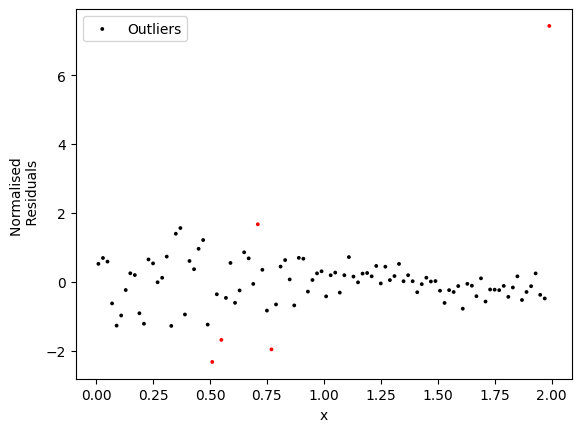

In [20]:
plt.figure(1)
# plt.axhline(0, color = "black", linestyle = '--')
# plt.axhline(1, color = "grey", linestyle = '--', alpha = 0.4)
# plt.axhline(-1, color = "grey", linestyle = '--', alpha = 0.4)
outliers = labels ==-1

plt.scatter(x_centres, residuals, c = np.where(outliers,'r','k'), s = 3, label = 'Data')
plt.legend(['Outliers', 'Inliers'])

plt.xlabel('x')
plt.ylabel('Normalised \n Residuals')

plt.show()

# Plot for the poster

In [21]:
dof = len(x_centres) - len(p0_osc)
chi_squared_min = chi_squared(popt_osc, oscillator_model, x_centres, pdf, y_std)
reduced_chi_squared = chi_squared_min/dof

print(chi_squared_min)
print(reduced_chi_squared)

8935.72691761512
91.18088691444001


In [30]:
min_index = np.unravel_index(np.argmin(contour_data), contour_data.shape)
p0_min_mesh = p0_axis[min_index[1]]
p1_min_mesh = p1_axis[min_index[0]]

print("Optimizer best-fit :", popt_osc)
print("Mesh best-fit      :", [p0_min_mesh, p1_min_mesh])
print("Difference         :", popt_osc - np.array([p0_min_mesh, p1_min_mesh]))


Optimizer best-fit : [0.56630644 0.99778595]
Mesh best-fit      : [np.float64(0.5661547954822785), np.float64(0.9973436869107152)]
Difference         : [0.00015165 0.00044227]


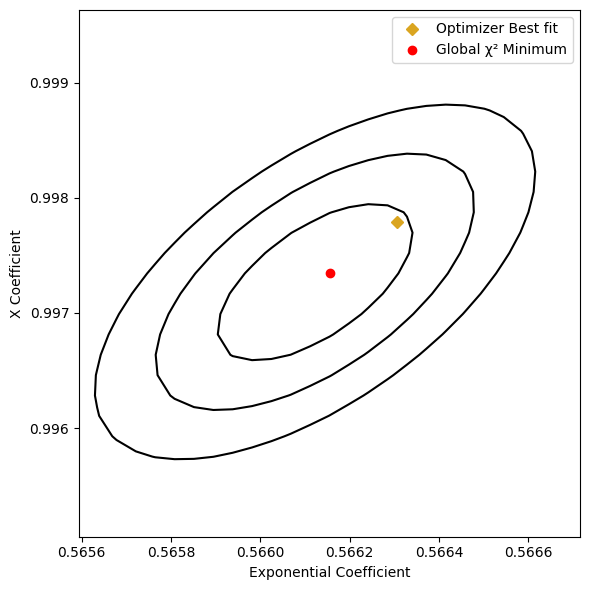

0.5663064408977662


In [37]:
#Plot for poster
center_p0 = p0_min_mesh
center_p1 = p1_min_mesh

assert(popt_osc.size == 2) # contour plot only 'works' for 2D parameter space!

extent = 3.01 # standard errors
n_points = 100 # mesh density

extent = 5  # 5σ window — wide enough to find Δχ²=1–9 region
n_points = 200

p0_axis = np.linspace(popt_osc[0] - extent*osc_err[0],
                      popt_osc[0] + extent*osc_err[0],
                      n_points)
p1_axis = np.linspace(popt_osc[1] - extent*osc_err[1],
                      popt_osc[1] + extent*osc_err[1],
                      n_points)

plot_data = np.zeros((n_points, n_points))
for j, p1_val in enumerate(p1_axis):
    for i, p0_val in enumerate(p0_axis):
        plot_data[j, i] = chi_squared([p0_val, p1_val],
                                      oscillator_model,
                                      x_centres,
                                      pdf,
                                      y_std)

chi_squared_min = np.min(plot_data)
contour_data = plot_data - chi_squared_min

X, Y = np.meshgrid(p0_axis, p1_axis)
levels = [1, 4, 9]

levels = [2.30, 6.18, 11.83]  # Correct for 2 parameters

plt.figure(figsize=(6,6))
contour_plot = plt.contour(X, Y, contour_data, levels=levels, colors='k')
plt.clabel(contour_plot, fmt=lambda x: rf'$\Delta\chi^2={x:.2f}$')

# Mark both minima visibly
plt.plot(popt_osc[0], popt_osc[1], 'D', markersize=6,
         label='Optimizer Best fit', color='goldenrod')
plt.plot(p0_min_mesh, p1_min_mesh, 'o', markersize=6,
         label='Global χ² Minimum', color='red')

# Center zoom using mesh-based minimum (correct global minimum)
zoom = 0.65
dx = zoom * osc_err[0]
dy = zoom * osc_err[1]

plt.xlim(center_p0 - dx, center_p0 + dx)
plt.ylim(center_p1 - dy, center_p1 + dy)


plt.xlabel('Exponential Coefficient')
plt.ylabel('X Coefficient')
plt.legend()
plt.tight_layout()
plt.show()


print(popt_osc[0])

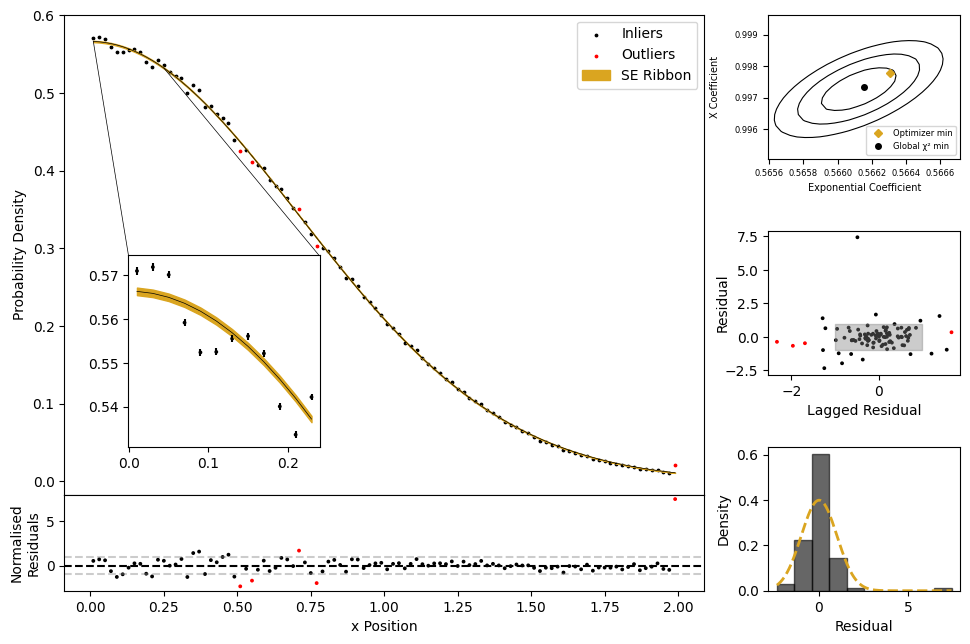

100


In [40]:
save_path = r"C:\Users\Sebastian\Documents\University work\Year 3\Computational Physics\Poster_Plot.svg"
goldenrod = (218/255,165/255,32/255)

fill_color = 'goldenrod'
inlier_color = 'black'
outlier_color = 'red'

fig = plt.figure(1)

#main plot
fig.add_axes([0,0,1,1])

plt.errorbar(x_centres[~outliers], pdf[~outliers],yerr = y_std[~outliers], color = inlier_color, linestyle ='none')
plt.errorbar(x_centres[outliers], pdf[outliers],yerr = y_std[outliers], color = outlier_color, linestyle ='none')
plt.scatter(x_centres[~outliers], pdf[~outliers], s=3, c=inlier_color, label='Inliers')
plt.scatter(x_centres[outliers], pdf[outliers], s=3, c=outlier_color, label='Outliers')


plt.plot(x_centres,oscillator_model(x_centres,popt_osc[0],popt_osc[1]), color = 'black', linewidth = 0.5)
plt.fill_between(x_centres,y_min, y_max, color = fill_color, label = 'SE Ribbon')

plt.xticks([])

plt.ylabel("Probability Density")
plt.legend()

#inset blowup of linesection

start_index = 0
end_index = 12
plt.plot([x_centres[start_index],0.13],[oscillator_model(x_centres[start_index],*popt_osc), 0.29], color = 'black', linewidth = 0.5)
plt.plot([x_centres[end_index],0.78],[oscillator_model(x_centres[end_index],*popt_osc), 0.29], color = 'black', linewidth = 0.5)

inset = fig.add_axes([0.1, 0.1, 0.3, 0.4])

inset.errorbar(x_centres[start_index:end_index], pdf[start_index:end_index],yerr = y_std[start_index:end_index], color = "black", linestyle ='none')
inset.plot(x_centres[start_index:end_index],oscillator_model(x_centres[start_index:end_index],popt_osc[0],popt_osc[1]), color = 'black', linewidth = 0.5)
inset.scatter(x_centres[start_index:end_index], pdf[start_index:end_index], s=3, c = np.where(outliers[start_index:end_index],outlier_color,inlier_color))

inset.fill_between(x_centres[start_index:end_index],y_min[start_index:end_index], y_max[start_index:end_index], color = fill_color)




#residual plot
fig.add_axes([0,-0.2,1,0.2])
plt.xlabel("x Position")
plt.ylabel("Normalised\nResiduals")

plt.axhline(0, color = 'black', linestyle = '--')
plt.axhline(1, color = 'grey', linestyle = '--',alpha = 0.4)
plt.axhline(-1, color = 'grey', linestyle = '--',alpha = 0.4)

plt.scatter(x_centres, residuals, c = np.where(outliers,outlier_color,inlier_color), s = 3)







# Contour plot (replacing Fit with Analytic Plot)
# --- Contour plot inset (global χ² minimum centered) --- #
cp = fig.add_axes([1.1, 0.7, 0.3, 0.3])

# Use previously computed contour_data, p0_axis, p1_axis, X, Y
levels = [2.30, 6.18, 11.83]  # 1σ, 2σ, 3σ levels for 2 fitted parameters

contour_plot = cp.contour(X, Y, contour_data, levels=levels,
                          colors='k', linewidths=0.8)
cp.clabel(contour_plot, fmt=lambda x: rf'$\Delta\chi^2={x:.2f}$',
          fontsize=6)

# Mark both minima
cp.plot(popt_osc[0], popt_osc[1], 'D', markersize=4,
        label='Optimizer min', color='goldenrod')
cp.plot(p0_min_mesh, p1_min_mesh, 'o', markersize=4,
        label='Global χ² min', color='black')

# Zoom centered on mesh-based minimum
zoom = 0.65
dx = zoom * osc_err[0]
dy = zoom * osc_err[1]

cp.set_xlim(center_p0 - dx, center_p0 + dx)
cp.set_ylim(center_p1 - dy, center_p1 + dy)

# Labels & formatting
cp.set_xlabel('Exponential Coefficient', fontsize=7)
cp.set_ylabel('X Coefficient', fontsize=7)
cp.tick_params(labelsize=6)
cp.yaxis.set_label_coords(-0.25, 0.5)
cp.legend(fontsize=6, loc='lower right')




#Lagplot
lp = fig.add_axes([1.1, 0.25, 0.3, 0.3])
#lp.set_title('Residual Lagplot')
lp.set_xlabel('Lagged Residual')
lp.set_ylabel('Residual')
lp.yaxis.set_label_coords(-0.2, 0.5)
R_1 = residuals[0:len(residuals)-1]
R_i = residuals[1:]

lp.scatter(R_1,R_i, s = 3, c = np.where(outliers[0:len(outliers)-1],outlier_color,inlier_color))
lp.fill_between([-1,1],1,-1, color = 'grey', alpha = 0.4)





# Residual histogram plot
hp = fig.add_axes([1.1, -0.2, 0.3, 0.3])
hp.set_xlabel('Residual')
hp.set_ylabel('Density')

# Fit a normal distribution to residuals
mu, std = norm.fit(residuals)

# Plot histogram
n, bins, patches = hp.hist(residuals, bins=10, density=True, color='black', edgecolor='black', alpha=0.6)

# Generate smooth Gaussian curve
x = np.linspace(min(bins), max(bins), 200)
hist_gauss = norm.pdf(x, mu, std)

# Overlay the fitted Gaussian
hp.plot(x, hist_gauss, '--', linewidth=2, color = fill_color)

plt.savefig(save_path, bbox_inches='tight', format = 'svg')
plt.show()
print(len(x_centres))

In [24]:
print(f"The exponential coefficient in the model was {popt_osc[0]} ± {osc_err[0]} which is bounded as \n[{popt_osc[0]-osc_err[0]},{popt_osc[0]+osc_err[0]}]. The true value is {1/np.sqrt(np.pi)} \nThe x coefficient in the model was {popt_osc[1]} ± {osc_err[1]} which is bounded as \n[{popt_osc[1]-osc_err[1]},{popt_osc[1]+osc_err[1]}]. The true value is 1.")

print(f"The Reduced chi squared = {reduced_chi_squared}")

The exponential coefficient in the model was 0.5663064408977662 ± 0.0008622125052011314 which is bounded as 
[0.565444228392565,0.5671686534029673]. The true value is 0.5641895835477563 
The x coefficient in the model was 0.9977859544398356 ± 0.003520449531799282 which is bounded as 
[0.9942655049080363,1.0013064039716348]. The true value is 1.
The Reduced chi squared = 91.18088691444001


In [25]:
A = np.sum(pdf[i_099:i_101]* dx)
B = np.sum(phi_sq_analytic[i_099:i_101]* dx)
percent = ((B-A)/B)*100
print(f"The probability of the particle being located between x = [0.99,1.01] was P(0.99<x<1) = {A}\nThe theoretical probalbity of P(0.99<x<1.01) = {B}\nThus the disagreement was {percent}")

The probability of the particle being located between x = [0.99,1.01] was P(0.99<x<1) = 0.004289019673450681
The theoretical probalbity of P(0.99<x<1.01) = 0.004254403892065027
Thus the disagreement was -0.8136458658806859
